# LIBRARIES TO BE USED

In [1]:
# To import dataset and manage using Githube.com ( https://github.com/viniciusparede/house-prices-prediction-ppgia )
import os
import git

# Data Manipulation and Calculation
import pandas as pd
import numpy as np
import math
from scipy.stats import mode
from sklearn.neighbors import KNeighborsRegressor
from skrebate import ReliefF
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


# Charts and visualization
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker

# LOAD DATA SET FROM GITHUB

In [2]:
# Function to load dataset from githun
def get_git_root(path) -> str:
    git_repo = git.Repo(path, search_parent_directories=True)
    git_root = git_repo.git.rev_parse("--show-toplevel")
    return git_root


git_dir = get_git_root(os.getcwd()) # Github folder where dataset is storaged.
data_dir = os.path.join(git_dir, "data") # Data folder

# Import dataset to a DataFrame
df_train = pd.read_csv(os.path.join(data_dir, "train.csv")) # [!] main dataset to be analyzed
df_test = pd.read_csv(os.path.join(data_dir, "test.csv"))

In [3]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


# GROUP OF QUESTIONS #1:
# DATASET DESCRIPTION (DESCRIÇÃO DA BASE DE DADOS)

1) Indicar o nome da base:

House Prices ( https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/rules )


2) Que tipo de dado (ou problema) caracteriza esta base de dados, ou seja, o que se pretende extrair de conhecimento a partir dos dados lá disponíveis (classificação/regressão, agrupamento, associação, por exemplo):

Classificação/regressão e agrupamento


3) Indicar quem forneceu esta base, além da data da coleta dos dados (início e final), além de particularidades (por exemplo, a coleta foi interrompida durante um período de tempo e depois retomada):

O próprio site da Kaggle forneceu a base de dados como forma de competição. Mesmo analisando os metadados da base e o arquivo “data_description.txt”, não foi possível identificar a data de coleta dos dados e a data de criação da base de dados


4) Indicar se existem informações já publicadas sobre seu uso e, em caso positivo, onde foi publicado, por quem, o quê:

Sim, há publicações prévias e devido ao fato da base ser uma base de competição, existem vários notebooks já publicados, no próprio site do Kaggle ( https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/code?competitionId=5407&sortBy=scoreAscending )



5) Quantas classes existem e quais são elas, no caso de classificação, ou o nome e a faixa de valores da variável a ser prevista no caso de regressão:

Existem 81 classes/colunas/atributos no arquivo com diversos tipos de variáveis.  numéricas (sejam intervalos ou ratios) e categóricas (nominais ou ordinais). As faixas de valores e tipos de variáveis podem ser vistos no arquivo "data_description.txt".




# GROUP OF QUESTIONS #2:
# DATASET FEATURES (CARACTERÍSTICAS DA BASE DE DADOS)

There are 14 question in this group and each question will be in it own markdown field below.

1) Quantas instâncias existem?

Existe 1460 instâncias, conforme código abaixo.


2) Quantos atributos existem?

Existem 81 atributos/colunas, conforme código abaixo.

In [5]:
print(df_train.shape) #Check size of df_train

(1460, 81)


3) O tipo de cada atributo?

Vide na lista (Dtype) e no gráfico abaixo, sendo que "int64" e "float64" são variáveis numéricas e "objects" são variáveis categóricas.

In [6]:
df_train.info() #Check the df_train properties, including the type of each atribute/column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

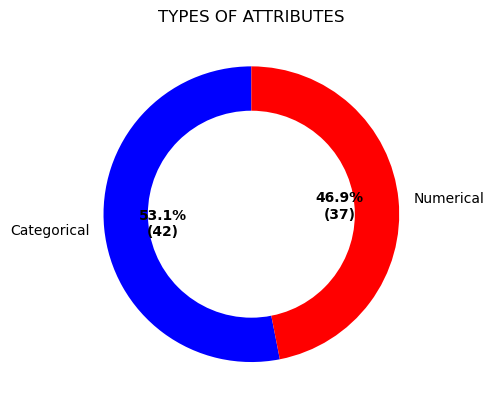

In [7]:
#ACCOUNTING THE TYPES OF ATTRIBUTES

dtypes_count = df_train.dtypes.replace({'float64': 'Numerical', 'int64': 'Numerical', 'object': 'Categorical'}).value_counts()
### Create a chart to show it
sizes = dtypes_count.values
labels = dtypes_count.index.astype(str)
colors = ['blue', 'red']

fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(sizes, labels=labels, colors=colors, autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*sizes.sum())})', startangle=90)
plt.setp(autotexts, size=10, weight='bold')
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)
plt.title('TYPES OF ATTRIBUTES', loc='center')
plt.show()
### ENF OF Create a chart to show it



4) Há informações sobre ruído? Em caso positivo, quais?

Não existem ruídos propriamente ditos, pois esta base não se trata de uma série temporal.
Foram identificados colunas onde um valor NULL ou n/a preenchido não significa vazio e sim que tal atributo pode ser zero ou não existe na casa. Exemplo: PoolQC (Qualidade da Piscina), onde um valor NULL em sua célula significa que não há piscina naquela casa:

        PoolQC: Pool quality
                
            Ex	Excellent
            Gd	Good
            TA	Average/Typical
            Fa	Fair
            NA	No Pool


Diante das variáveis e análises univariadas e multivariadas que fizemos, não identificamos ruídos nos dados. Foram identificados outliers muito fora dos quartis, porém foi dado o benefício da dúvida que ali não se trata de um ruído e sim uma variabilidade de mercado, que segundo Richard H. Thaler, comporta-se de forma irracional em amplos âmbitos de negociação e avaliação.


In [8]:
# Calcular a porcentagem de valores ausentes em cada coluna com valores ausentes maiores que 0
missing_data = df_train.isnull().sum()[df_train.isnull().sum() > 0]
missing_data_percentage = missing_data / len(df_train) * 100

# Combinar as informações em um dataframe
df_train_missing_values = pd.concat(
    [missing_data, missing_data_percentage], axis=1, keys=["Total", "Percentage"]
)

# Ordenar os valores pela porcentagem de valores ausentes em ordem decrescente
df_train_missing_values = df_train_missing_values.sort_values(by="Percentage", ascending=False)

df_train_missing_values




,Total,Percentage
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945
GarageQual,81,5.547945


In [9]:
#FILL MISSING VALUES AND CHECK AGAIN

# Lista de colunas que precisam ser preenchidas com "NA"
cols_to_fillna = [
    "PoolQC",
    "MiscFeature",
    "Alley",
    "Fence",
    "FireplaceQu",
    "GarageType",
    "GarageFinish",
    "GarageQual",
    "GarageCond",
    "BsmtExposure",
    "BsmtFinType2",
    "BsmtFinType1",
    "BsmtCond",
    "BsmtQual",
]

df_train_filled = df_train.copy()

# Usando uma compreensão de lista para preencher os valores ausentes com "NA" em cada coluna
for col in cols_to_fillna:
    df_train_filled[col].fillna("NA", inplace=True)

# Preenchendo os valores ausentes no atributo "LotFrontage" com o valor padrão "0"
df_train_filled["LotFrontage"].fillna(0, inplace=True)

# Preenchendo os valores ausentes no atributo "GarageYrBlt" com o valor padrão "0"
df_train_filled["GarageYrBlt"].fillna(0, inplace=True)

# Excluindo as instâncias com valores ausentes (conjunto pequeno em relação ao tamanho do conjunto de dados)
cols_to_dropna = ["MasVnrType", "MasVnrArea", "Electrical"]
df_train_filled.dropna(subset=cols_to_dropna, inplace=True)
#df_train_filled.drop(columns=["Id"], inplace=True)

5) Há indicação de outliers?

Diante das variáveis e análises univariadas e multivariadas que fizemos, não identificamos ruídos nos dados. Foram identificados outliers muito fora dos quartis, porém foi dado o benefício da dúvida que ali não se trata de um ruído e sim uma variabilidade de mercado, que segundo Richard H. Thaler, comporta-se de forma irracional em amplos âmbitos de negociação e avaliação.

Sim. Dado a dimensão dessa base de dados seria estranho se algum dos 80 atributos não apresentassem outliers. Abaixo segue um exemplo onde o Preço de Vendas (SalePrice) é confrontrado, em boxplot, com outras variáveis como Vizinhança (Neighborhoo), Condição Geral do Imóvel (OverallCond) e Qualidade Geral do imóvel (OverallQual).

In [10]:
#CHECK OUTLIERS

#First, split the columns in two groups: Categorical and Numerical
numericos = list(df_train.select_dtypes(include=['int64', 'float64']).columns)
categoricos = list(df_train.select_dtypes(include=['object']).columns)
print('### THE NUMERICAL COLUMNS ARE:')
print(numericos)
print('\n### THE CATEGORICAL COLUMNS ARE:')
print(categoricos)
print(f'\nTOTAL COLUMNS ANALYZED ARE: {len(numericos) + len(categoricos)}')

### THE NUMERICAL COLUMNS ARE:
['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']

### THE CATEGORICAL COLUMNS ARE:
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',

In [11]:
df_train_filled[df_train_filled.isnull().any(axis=1)]


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [12]:
from sklearn.preprocessing import LabelEncoder

# Create a new DataFrame to store the label-encoded data
df_train_filled_encoded = df_train_filled.copy()

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()
mapa_de_legendas = {}
# Iterate over each column in the DataFrame
for col in df_train_filled.columns:
    # Check if the column contains categorical data
    if df_train_filled[col].dtype == 'object':
        # Apply LabelEncoder to the categorical column
        df_train_filled_encoded[col] = label_encoder.fit_transform(df_train_filled[col])
        mapa_de_legendas[col] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))


# Print the updated DataFrame with label-encoded data

df_train_filled_encoded[df_train_filled_encoded.isnull().any(axis=1)]


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [13]:
scaler = StandardScaler()

columns_to_standardize = [
    "LotArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MiscVal",
    "LotFrontage",
    "MasVnrArea",
]

# Padronizando as colunas selecionadas
df_train_filled_encoded[columns_to_standardize] = scaler.fit_transform(df_train_filled_encoded[columns_to_standardize])
#test[columns_to_standardize] = scaler.fit_transform(test[columns_to_standardize])

In [14]:
# Print the label mapping dictionary
print('\n\n### LABEL MAP OF CATEGORICAL COLUMNS ENCODED')
for col, mapping in mapa_de_legendas.items():
    print(f"\nLabel Mapping for column '{col}':")
    for category, encoded_value in mapping.items():
        print(f"{category}: {encoded_value}")
print('### END OF LABEL MAP OF CATEGORICAL COLUMNS ENCODED\n\n')



### LABEL MAP OF CATEGORICAL COLUMNS ENCODED

Label Mapping for column 'MSZoning':
C (all): 0
FV: 1
RH: 2
RL: 3
RM: 4

Label Mapping for column 'Street':
Grvl: 0
Pave: 1

Label Mapping for column 'Alley':
Grvl: 0
NA: 1
Pave: 2

Label Mapping for column 'LotShape':
IR1: 0
IR2: 1
IR3: 2
Reg: 3

Label Mapping for column 'LandContour':
Bnk: 0
HLS: 1
Low: 2
Lvl: 3

Label Mapping for column 'Utilities':
AllPub: 0
NoSeWa: 1

Label Mapping for column 'LotConfig':
Corner: 0
CulDSac: 1
FR2: 2
FR3: 3
Inside: 4

Label Mapping for column 'LandSlope':
Gtl: 0
Mod: 1
Sev: 2

Label Mapping for column 'Neighborhood':
Blmngtn: 0
Blueste: 1
BrDale: 2
BrkSide: 3
ClearCr: 4
CollgCr: 5
Crawfor: 6
Edwards: 7
Gilbert: 8
IDOTRR: 9
MeadowV: 10
Mitchel: 11
NAmes: 12
NPkVill: 13
NWAmes: 14
NoRidge: 15
NridgHt: 16
OldTown: 17
SWISU: 18
Sawyer: 19
SawyerW: 20
Somerst: 21
StoneBr: 22
Timber: 23
Veenker: 24

Label Mapping for column 'Condition1':
Artery: 0
Feedr: 1
Norm: 2
PosA: 3
PosN: 4
RRAe: 5
RRAn: 6
RRNe: 7
RRN

In [15]:
#CALCULATE OUTLIERS

# Calculate IQR per column
q1 = df_train_filled_encoded.quantile(0.25)
q3 = df_train_filled_encoded.quantile(0.75)
iqr = q3 - q1
# END OF Calculate IQR per column

# According the IQ Method, outliers are those values above or below of 1.5*IQR
lower_threshold = q1 - 1.5 * iqr
upper_threshold = q3 + 1.5 * iqr
# According the IQ Method, outliers are those values above or below of 1.5*IQR

# Identifica as colunas com outliers
outlier_columns = df_train_filled_encoded.columns[(df_train_filled_encoded > upper_threshold).any()]
outlier_columns = df_train_filled_encoded.columns[(df_train_filled_encoded < lower_threshold).any()]
outlier_column_names = outlier_columns.tolist()

# Imprime a lista de colunas com outliers
print('### CATEGORICAL COLUMNS WITH OUTLIERS VALUES:')
outlier_categorical_columns = [item for item in categoricos if item in outlier_column_names]
print(outlier_categorical_columns)
print(f'TOTAL NUMERICAL COLUMNS WITH OUTLIERS: {len(outlier_categorical_columns)} of {len(categoricos)}')
print('\n### NUMERICAL COLUMNS WITH OUTLIERS VALUES:')
outlier_numerical_columns = [item for item in numericos if item in outlier_column_names]
print(outlier_numerical_columns)
print(f'TOTAL NUMERICAL COLUMNS WITH OUTLIERS: {len(outlier_numerical_columns)} of {len(numericos)}')
print(f'\n\nTOTAL COLUMNS WITH OUTLIERS VALUES: {len(outlier_column_names)} of {len(df_train.columns)} ({round(len(outlier_column_names)/len(df_train.columns)*100,1)}%)')
print('#############')
print(outlier_numerical_columns)



### CATEGORICAL COLUMNS WITH OUTLIERS VALUES:
['MSZoning', 'Street', 'Alley', 'LandContour', 'Condition1', 'Condition2', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
TOTAL NUMERICAL COLUMNS WITH OUTLIERS: 28 of 43

### NUMERICAL COLUMNS WITH OUTLIERS VALUES:
['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'TotalBsmtSF', 'BedroomAbvGr', 'KitchenAbvGr', 'GarageYrBlt']
TOTAL NUMERICAL COLUMNS WITH OUTLIERS: 8 of 38


TOTAL COLUMNS WITH OUTLIERS VALUES: 36 of 81 (44.4%)
#############
['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'TotalBsmtSF', 'BedroomAbvGr', 'KitchenAbvGr', 'GarageYrBlt']


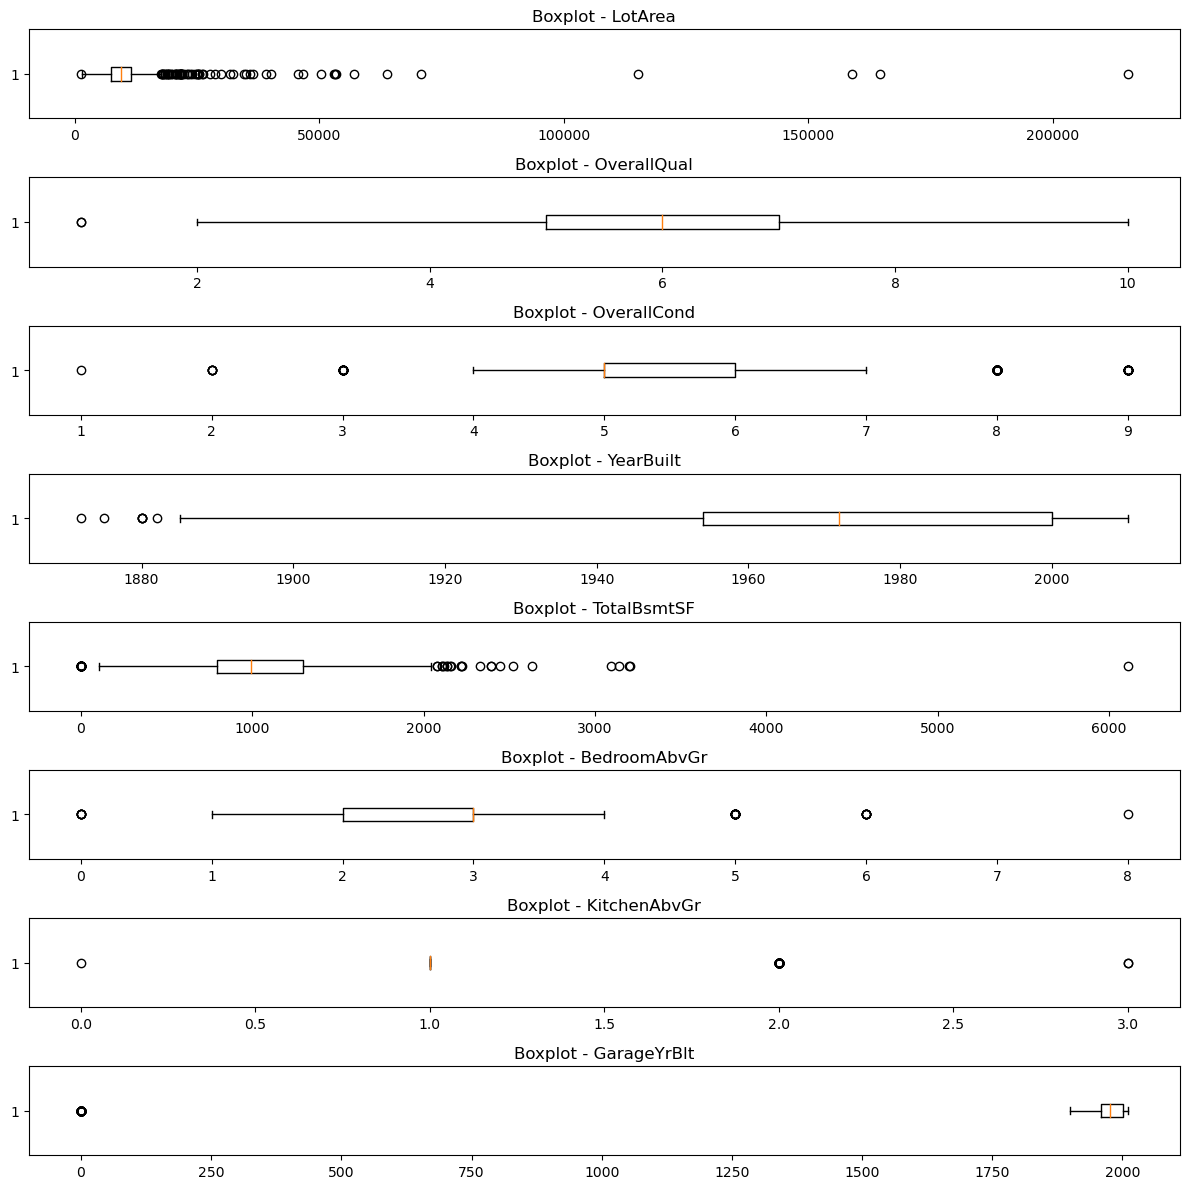

In [16]:
#PLOT BOXPLOT CHART FOR NUMERICAL COLUMNS WITH IDENFIED OUTLIERS VALUES

fig, axs = plt.subplots(len(outlier_numerical_columns), figsize=(12, 12))

for i, column in enumerate(outlier_numerical_columns):
    axs[i].boxplot(df_train_filled[column], vert=False)
    axs[i].set_title(f'Boxplot - {column}')

plt.tight_layout()
plt.show()



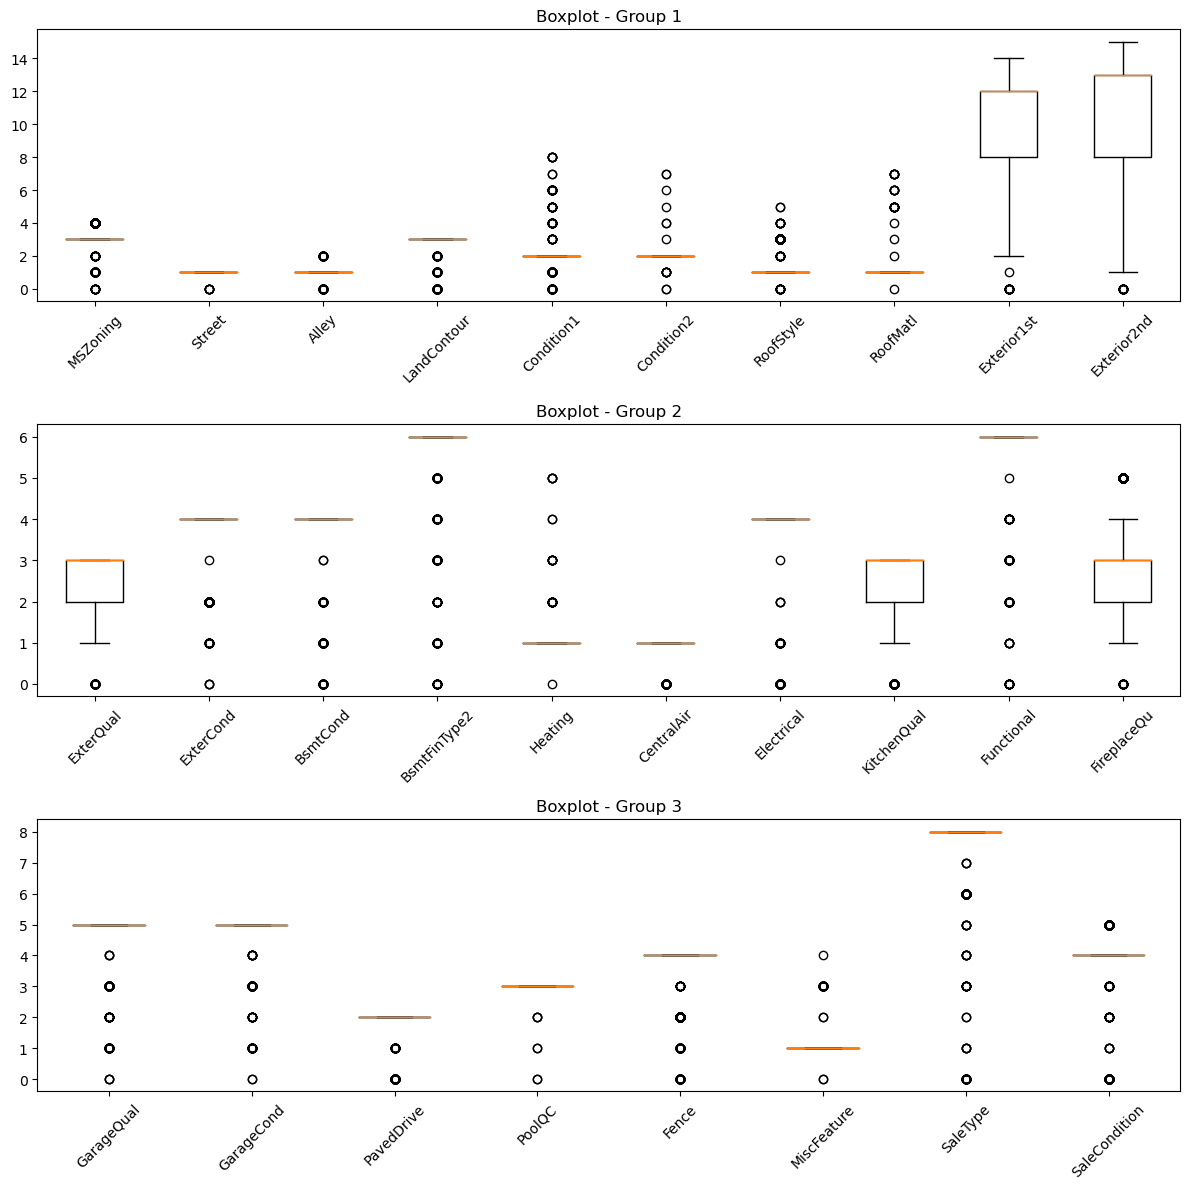

In [17]:
#PLOT BOXPLOT CHART FOR CATEGORICAL COLUMNS WITH IDENFIED OUTLIERS VALUES

num_plots = math.ceil(len(outlier_categorical_columns) / 10)

fig, axs = plt.subplots(num_plots, figsize=(12, 12))

for i in range(num_plots):
    start = i * 10
    end = min((i + 1) * 10, len(outlier_categorical_columns))
    columns_subset = outlier_categorical_columns[start:end]

    if num_plots > 1:
        axs_i = axs[i]
    else:
        axs_i = axs

    axs_i.boxplot(df_train_filled_encoded[columns_subset])
    axs_i.set_xticklabels(columns_subset, rotation=45)
    axs_i.set_title(f'Boxplot - Group {i + 1}')

plt.tight_layout()
plt.show()




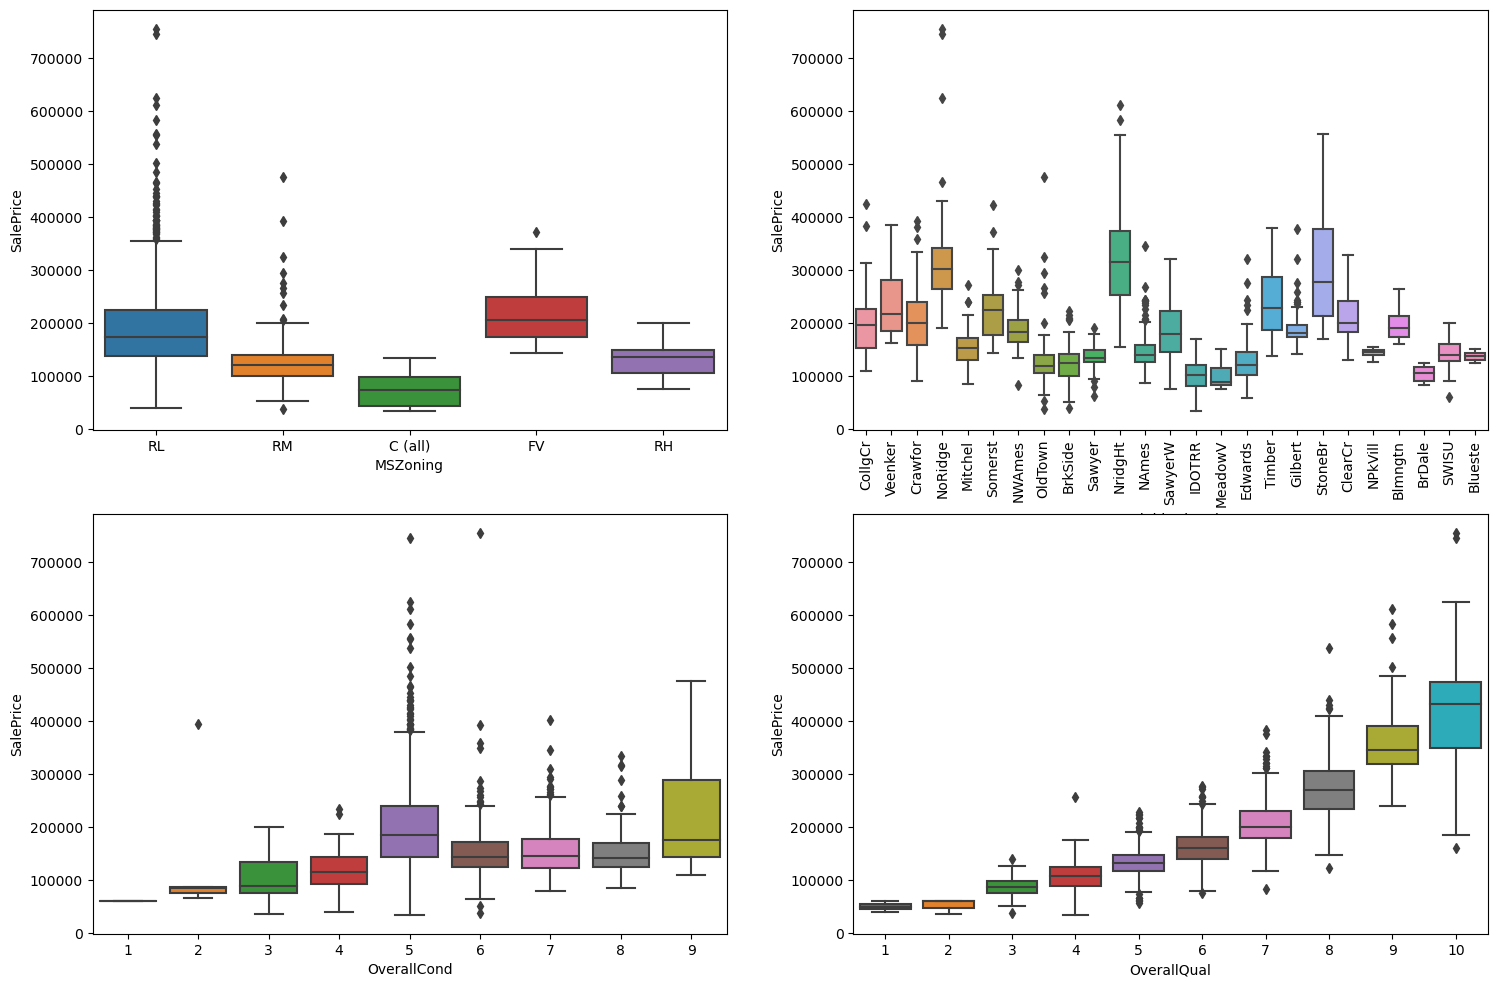

In [18]:
#Analyzing SalePrice columns with others


fig = plt.figure(figsize=(18, 12))

# Chart 1
fig.add_subplot(221)
#sns.countplot(df_train['MSZoning'])
sns.boxplot(x='MSZoning', y='SalePrice', data=df_train)
                 
# Chart 2
fig.add_subplot(222)
#sns.boxplot(x='MSZoning', y='SalePrice', data=df_train)
ax222=sns.boxplot(x='Neighborhood', y='SalePrice', data=df_train)

# Chart 3
fig.add_subplot(223)
#sns.boxplot(x='Neighborhood', y='SalePrice', data=df_train)
sns.boxplot(x='OverallCond', y='SalePrice', data=df_train)

# Chart 4
fig.add_subplot(224)
#sns.violinplot(x = 'OverallQual', y = 'SalePrice', data=df_train, palette='Set3', bw=.2, cut=1, split=True, linewidth=1)
sns.boxplot(x='OverallQual', y='SalePrice', data=df_train)

## Rotate ax222 by 90 degrees
ax222.tick_params(axis='x', labelrotation=90)

6) Existem dados faltantes?

Sim. Este item foi respodido na questão 4.

Quatro atributos (colunas) chamam a atenção por ter mais de 80% de dados faltantes (vide destaque em laranja na imagem acima).

In [19]:
#JUST TO SUMMARIZY THE QUANTITY OF MISSING VALUES PER COLUMNS

null_sum = df_train.isnull().sum()
null_cols = null_sum[null_sum>0]
num_instances = len(df_train)
for col_name, col_sum in null_cols.items():
    percent_missing = round((col_sum/num_instances)*100,2)
    print(f"{col_name}: {col_sum} ({percent_missing}%)")

LotFrontage: 259 (17.74%)
Alley: 1369 (93.77%)
MasVnrType: 8 (0.55%)
MasVnrArea: 8 (0.55%)
BsmtQual: 37 (2.53%)
BsmtCond: 37 (2.53%)
BsmtExposure: 38 (2.6%)
BsmtFinType1: 37 (2.53%)
BsmtFinType2: 38 (2.6%)
Electrical: 1 (0.07%)
FireplaceQu: 690 (47.26%)
GarageType: 81 (5.55%)
GarageYrBlt: 81 (5.55%)
GarageFinish: 81 (5.55%)
GarageQual: 81 (5.55%)
GarageCond: 81 (5.55%)
PoolQC: 1453 (99.52%)
Fence: 1179 (80.75%)
MiscFeature: 1406 (96.3%)


7) Em existindo dados faltantes, crie duas novas bases a partir da original, em que não existam dados faltantes usando dois métodos diferentes.

A primeira base já foi criado anteriormente respondendo a questão 4. Chama-se "df_train_filled", onde foi analisado que entre os atributos que possuiam dados faltantes ou N/A alguns poderiam ser substituido por zero, outros por "none" e outros por "not answered". Possibilitando uma tratativa melhor dos dados.

O segundo método é um método simples de exclusão das instâncias que possui alguma variável N/A. O resultado disso é zerar por completo as instâncias da base nova (df_train_na)

In [20]:
df_train_na = df_train.dropna()

df_train_na.info()
df_train_na

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             0 non-null      int64  
 1   MSSubClass     0 non-null      int64  
 2   MSZoning       0 non-null      object 
 3   LotFrontage    0 non-null      float64
 4   LotArea        0 non-null      int64  
 5   Street         0 non-null      object 
 6   Alley          0 non-null      object 
 7   LotShape       0 non-null      object 
 8   LandContour    0 non-null      object 
 9   Utilities      0 non-null      object 
 10  LotConfig      0 non-null      object 
 11  LandSlope      0 non-null      object 
 12  Neighborhood   0 non-null      object 
 13  Condition1     0 non-null      object 
 14  Condition2     0 non-null      object 
 15  BldgType       0 non-null      object 
 16  HouseStyle     0 non-null      object 
 17  OverallQual    0 non-null      int64  
 18  OverallCond    0 non-n

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


8) É possível agregar dados na base? Quais?

Sim, é possível, porém a base de dados já possui vários atributos, tornando a adição desnecessário para a predição do SalePriec.

Uma opção de adição de dados seria o de nível de criminalidade nos bairros das casas ou até mesmo o preechimento dos dados faltantes como foi feito.

9) Qual a proporção entre as clases?

Resposta no gráfico abaixo

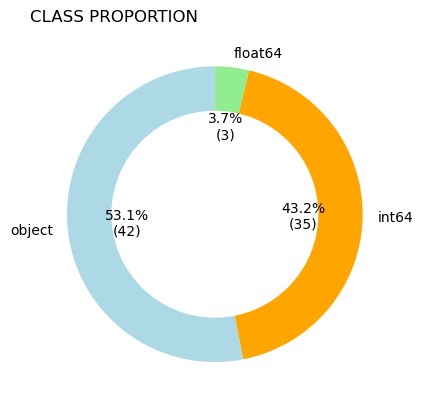

In [21]:
dtypes_count = df_train.dtypes.value_counts()
sizes = dtypes_count.values
labels = dtypes_count.index.astype(str)
colors = ['lightblue', 'orange', 'lightgreen']

#CHART
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=colors, autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*sizes.sum())})', startangle=90)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)
plt.title('CLASS PROPORTION', loc='left')
plt.show()

10) É necessário dimuir a dimensionalidade? Porquê?

Sim, faz-se necessário essa redução ainda mais que algumas variáveis possui pouca correlação com o target do trabalho que é o SalePrice (preço do imóvel). E como visto, algumas colunas?atributos, possuem mais de 90% de dados faltantes, sendo desnecessário ter essas colunas para nossas análises.

11) Apresente uma nova base com seleção de atributos usando o algoritmo Relief.

Vide códigos abaixo cujo produto é df_train_relief

In [22]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from skrebate import ReliefF
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# Separar os atributos e o atributo alvo
X = df_train_filled_encoded.drop("SalePrice", axis=1).values
y = df_train_filled_encoded["SalePrice"].values
estimator = LinearRegression()

# Criar o pipeline com o seletor de atributos ReliefF e o regressor RandomForestRegressor
clf = make_pipeline(ReliefF(n_features_to_select=10, n_neighbors=100),
                    RandomForestRegressor(n_estimators=estimator))

# Realizar a seleção de atributos
selector_relief = clf.named_steps['relieff']
selector_relief.fit(X, y)

# Obtendo os atributos selecionados e seus valores de influência
selected_features_relief = df_train_filled_encoded.drop("SalePrice", axis=1).columns[selector_relief.top_features_]
influence_values_relief = selector_relief.feature_importances_[selector_relief.top_features_]

# Ordenar os atributos pelo valor de influência
sorted_indices = np.argsort(influence_values_relief)[::-1][:10]
selected_features_relief = selected_features_relief[sorted_indices]
influence_values_relief = influence_values_relief[sorted_indices]

# Criando a lista de resultado
result_relief = list(zip(selected_features_relief, influence_values_relief))

# Criar o dataframe df_relief com as colunas selecionadas e a coluna SalePrice
selected_columns = [col for col, _ in result_relief]
df_train_relief = df_train_filled_encoded[selected_columns].copy()

df_train_relief = df_train_relief.join(df_train_filled_encoded['SalePrice'])


print(result_relief)
print(df_train_relief)


[('GrLivArea', 0.3865214263551664), ('OverallQual', 0.350947508457), ('ExterQual', 0.3257679457824918), ('KitchenQual', 0.3174443205611354), ('GarageCars', 0.30928392961899026), ('BsmtQual', 0.30843765744589274), ('FullBath', 0.29173416863556556), ('1stFlrSF', 0.28541164466491653), ('TotalBsmtSF', 0.2730850296614107), ('GarageArea', 0.26666733442471235)]
      GrLivArea  OverallQual  ExterQual  KitchenQual  GarageCars  BsmtQual  \
0      0.372562            7          2            2           2         2   
1     -0.479767            6          3            3           2         2   
2      0.517154            7          2            2           2         2   
3      0.385880            7          3            2           3         4   
4      1.300993            8          2            2           3         2   
...         ...          ...        ...          ...         ...       ...   
1455   0.252704            6          3            3           2         2   
1456   1.063178    

In [23]:
# Verificar linhas com células vazias
rows_with_null = df_train_filled_encoded[df_train_filled_encoded.isnull().any(axis=1)]

# Imprimir as linhas com células vazias
print(rows_with_null)


Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, PoolQC, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice]
Index: []

[0 rows x 81 columns]


In [24]:
result_relief

[('GrLivArea', 0.3865214263551664),
 ('OverallQual', 0.350947508457),
 ('ExterQual', 0.3257679457824918),
 ('KitchenQual', 0.3174443205611354),
 ('GarageCars', 0.30928392961899026),
 ('BsmtQual', 0.30843765744589274),
 ('FullBath', 0.29173416863556556),
 ('1stFlrSF', 0.28541164466491653),
 ('TotalBsmtSF', 0.2730850296614107),
 ('GarageArea', 0.26666733442471235)]

In [25]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# Criando o estimador de regressão
regressor = RandomForestRegressor(n_estimators=100, max_depth=10)

# Removendo a coluna "SalePrice" do dataframe
df_train_features = df_train_filled_encoded.drop("SalePrice", axis=1)

# Criando o seletor de atributos RFE
selector = RFE(estimator=regressor, n_features_to_select=10)

# Realizando a seleção de atributos
selector.fit(df_train_features, df_train_filled_encoded["SalePrice"])

# Obtendo os atributos selecionados
selected_features = df_train_features.columns[selector.support_]
importance_values = selector.estimator_.feature_importances_

# Criando a lista de resultado
result_rfe = list(zip(selected_features, importance_values))
result_rfe


[('LotArea', 0.024416890115848484),
 ('OverallQual', 0.5993255526869525),
 ('YearBuilt', 0.02918276613241848),
 ('BsmtFinSF1', 0.04187527029814988),
 ('TotalBsmtSF', 0.05261243818400691),
 ('1stFlrSF', 0.03022993300362896),
 ('2ndFlrSF', 0.04496098147878287),
 ('GrLivArea', 0.13085069646759637),
 ('GarageCars', 0.018777283233513235),
 ('GarageArea', 0.027768188399102372)]

In [26]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression


# Definindo o número desejado de atributos selecionados
k = 10

# Criando o seletor de atributos Information Gain
selector_info_gain = SelectKBest(score_func=mutual_info_regression, k=k)
selector_info_gain.fit(df_train_filled_encoded.drop("SalePrice", axis=1), df_train_filled_encoded["SalePrice"])

# Obtendo os índices dos atributos selecionados
selected_indices_info_gain = selector_info_gain.get_support(indices=True)

# Obtendo os atributos selecionados e seus scores
selected_features_info_gain = df_train_filled_encoded.drop("SalePrice", axis=1).columns[selected_indices_info_gain]
scores_info_gain = selector_info_gain.scores_[selected_indices_info_gain]

result_info_gain = list(zip(selected_features_info_gain, scores_info_gain))
result_info_gain


[('Neighborhood', 0.5097562233105637),
 ('OverallQual', 0.5807616389297476),
 ('YearBuilt', 0.3639312660919991),
 ('ExterQual', 0.32722299795577303),
 ('BsmtQual', 0.316085012097824),
 ('TotalBsmtSF', 0.3606272197217142),
 ('GrLivArea', 0.48015817233670344),
 ('KitchenQual', 0.3189824707775437),
 ('GarageCars', 0.36477893769024905),
 ('GarageArea', 0.3635095419940324)]

In [27]:
from sklearn.feature_selection import f_regression
# Criando o seletor de atributos Gini Gain
selector_gini_gain = SelectKBest(score_func=f_regression, k=k)
selector_gini_gain.fit(df_train_filled_encoded.drop("SalePrice", axis=1), df_train_filled_encoded["SalePrice"])

# Obtendo os índices dos atributos selecionados
selected_indices_gini_gain = selector_gini_gain.get_support(indices=True)

# Obtendo os atributos selecionados e seus scores
selected_features_gini_gain = df_train_filled_encoded.drop("SalePrice", axis=1).columns[selected_indices_gini_gain]
scores_gini_gain = selector_gini_gain.scores_[selected_indices_gini_gain]

result_gini_gain = list(zip(selected_features_gini_gain, scores_gini_gain))
result_gini_gain


[('OverallQual', 2407.1250833446165),
 ('ExterQual', 972.1593477027561),
 ('BsmtQual', 783.5456787629048),
 ('TotalBsmtSF', 873.6216680313061),
 ('1stFlrSF', 845.2133360760246),
 ('GrLivArea', 1473.5718609227392),
 ('FullBath', 671.4123686684883),
 ('KitchenQual', 760.5076194214878),
 ('GarageCars', 1003.9352531139435),
 ('GarageArea', 916.659400886515)]

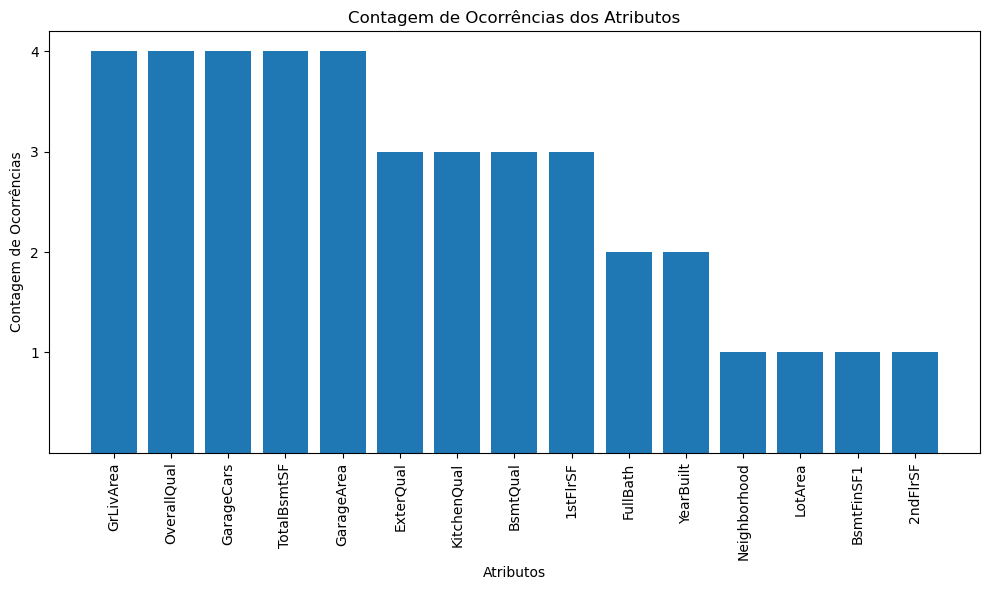

In [28]:
import matplotlib.pyplot as plt

conjunto_de_listas = [result_relief, result_info_gain, result_gini_gain, result_rfe]

# Criar um dicionário para armazenar a contagem de ocorrências de cada string
count_dict = {}

# Varrer as listas dentro de "conjunto_de_listas" e atualizar a contagem para cada string
for lista in conjunto_de_listas:
    for column, _ in lista:
        count_dict[column] = count_dict.get(column, 0) + 1

# Extrair as colunas e as contagens do dicionário
columns_count = list(count_dict.keys())
count_values = list(count_dict.values())

# Ordenar as colunas e contagens com base nas contagens em ordem decrescente
columns_count, count_values = zip(*sorted(zip(columns_count, count_values), key=lambda x: x[1], reverse=True))

# Criar o gráfico de barras
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(columns_count, count_values)
ax.set_xlabel('Atributos')
ax.set_ylabel('Contagem de Ocorrências')
ax.set_title('Contagem de Ocorrências dos Atributos')
plt.xticks(rotation=90)
plt.yticks(range(1, max(count_values) + 1))

plt.tight_layout()
plt.show()


In [29]:
conjunto_de_listas = [result_relief, result_info_gain, result_gini_gain, result_rfe]

count_dict = {}

for lista in conjunto_de_listas:
    for column, _ in lista:
        count_dict[column] = count_dict.get(column, 0) + 1

only_one = []

for column in count_dict:
    if count_dict[column] == 1:
        for lista, nome_lista in zip(conjunto_de_listas, ["result_relief", "result_info_gain", "result_gini_gain", "result_rfe"]):
            if column in [item[0] for item in lista]:
                only_one.append(f"{column} ({nome_lista})")

print(only_one)


['Neighborhood (result_info_gain)', 'LotArea (result_rfe)', 'BsmtFinSF1 (result_rfe)', '2ndFlrSF (result_rfe)']


In [30]:
conjunto_de_listas = [result_relief, result_info_gain, result_gini_gain, result_rfe]

count_dict = {}

for lista in conjunto_de_listas:
    for column, _ in lista:
        count_dict[column] = count_dict.get(column, 0) + 1

top_10_features = [feature for feature, _ in sorted(count_dict.items(), key=lambda x: x[1], reverse=True)[:10]]

listas_mais_influente = []

for lista, nome_lista in zip(conjunto_de_listas, ["result_relief", "result_info_gain", "result_gini_gain", "result_rfe"]):
    count = sum(1 for feature in top_10_features if feature in [item[0] for item in lista])
    listas_mais_influente.append((nome_lista, count))

listas_mais_influente = sorted(listas_mais_influente, key=lambda x: x[1], reverse=True)

print("Top 10 Features:")
for feature in top_10_features:
    print(feature)

print("\nListas Mais Influente:")
for lista, count in listas_mais_influente:
    print(f"{lista}: {count}")


Top 10 Features:
GrLivArea
OverallQual
GarageCars
TotalBsmtSF
GarageArea
ExterQual
KitchenQual
BsmtQual
1stFlrSF
FullBath

Listas Mais Influente:
result_relief: 10
result_gini_gain: 10
result_info_gain: 8
result_rfe: 6


C:\Users\tavar\AppData\Local\Temp\ipykernel_10276\430093218.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(columns_relief, rotation=90)


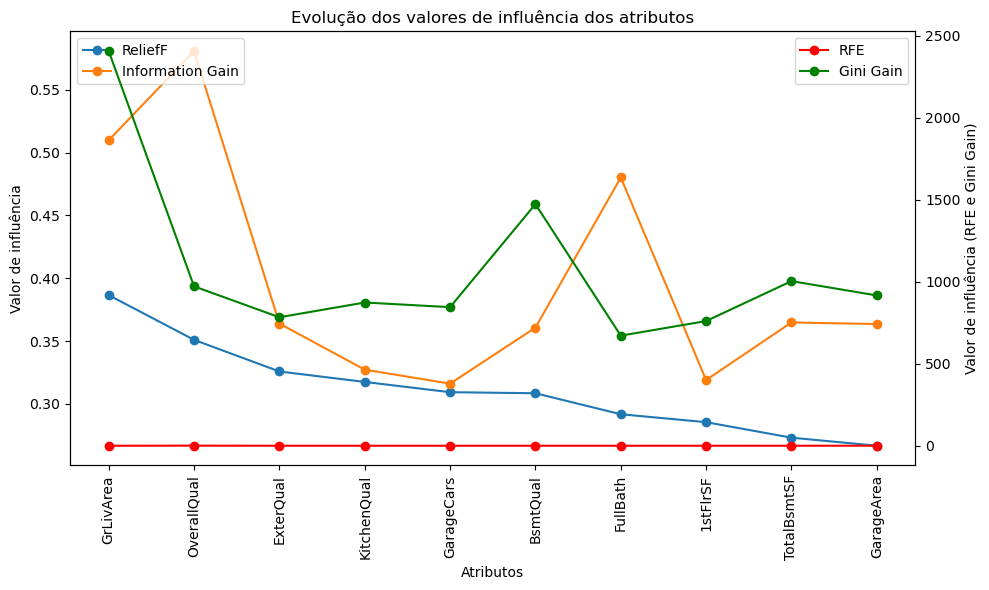

In [31]:
import matplotlib.pyplot as plt

# Extrair os nomes das colunas e os valores de influência de cada lista
columns_relief, values_relief = zip(*result_relief)
columns_info_gain, values_info_gain = zip(*result_info_gain)
columns_gini_gain, values_gini_gain = zip(*result_gini_gain)

# Extrair os nomes das colunas e os valores de influência de result_rfe e result_gini_gain
columns_rfe, values_rfe = zip(*result_rfe)
columns_gini, values_gini = zip(*result_gini_gain)

# Criar um dicionário para mapear as colunas aos valores de influência
data = {
    'ReliefF': values_relief,
    'Information Gain': values_info_gain,
    'Gini Gain': values_gini_gain
}

# Criar um gráfico de linha para mostrar a evolução dos valores
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(columns_relief, values_relief, marker='o', label='ReliefF')
ax1.plot(columns_relief, values_info_gain, marker='o', label='Information Gain')
ax1.set_xlabel('Atributos')
ax1.set_ylabel('Valor de influência')
ax1.set_title('Evolução dos valores de influência dos atributos')
ax1.set_xticklabels(columns_relief, rotation=90)
ax1.legend(loc='upper left')

# Criar um segundo eixo y para result_rfe e result_gini_gain
ax2 = ax1.twinx()
ax2.plot(columns_relief, values_rfe, marker='o', color='red', label='RFE')
ax2.plot(columns_relief, values_gini, marker='o', color='green', label='Gini Gain')
ax2.set_ylabel('Valor de influência (RFE e Gini Gain)')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()



12) Apresente uma nova base com variáveis discretizadas por dois métodos diferentes;

Os dois métodos será aplicados a base df_train_relief.

Os métodos escolhidos foram o Binning (Discretização por Intervalos) e K-Mean.

A primeira base modificada chama-se df_train_relief_binning e a segunda df_train_relief_kmean.

Ambas oriundas de df_train_filled_encoded.

In [32]:
#BINNING METHOD TO DISCRETIZER
#from sklearn.preprocessing import KBinsDiscretizer

discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

df_train_relief_binning = df_train_relief.drop('SalePrice', axis=1)  # Remove a coluna "SalePrice" do dataframe

for column in df_train_relief_binning.columns:
    if pd.api.types.is_numeric_dtype(df_train_relief_binning[column]):
        column_values = df_train_relief_binning[column].values.reshape(-1, 1)
        column_binned = discretizer.fit_transform(column_values)
        df_train_relief_binning[column] = column_binned.flatten()

df_train_relief_binning['SalePrice'] = df_train['SalePrice']

df_train_relief_binning



,GrLivArea,OverallQual,ExterQual,KitchenQual,GarageCars,BsmtQual,FullBath,1stFlrSF,TotalBsmtSF,GarageArea,SalePrice
0,1.0,3.0,3.0,3.0,2.0,2.0,3.0,0.0,0.0,1.0,208500
1,0.0,2.0,4.0,4.0,2.0,2.0,3.0,1.0,1.0,1.0,181500
2,1.0,3.0,3.0,3.0,2.0,2.0,3.0,0.0,0.0,2.0,223500
3,1.0,3.0,4.0,3.0,3.0,4.0,1.0,0.0,0.0,2.0,140000
4,1.0,3.0,3.0,3.0,3.0,2.0,3.0,0.0,0.0,2.0,250000
...,...,...,...,...,...,...,...,...,...,...,...
1455,1.0,2.0,4.0,4.0,2.0,2.0,3.0,0.0,0.0,1.0,175000
1456,1.0,2.0,4.0,4.0,2.0,2.0,3.0,1.0,1.0,1.0,210000
1457,1.0,3.0,0.0,3.0,1.0,4.0,3.0,0.0,0.0,0.0,266500
1458,0.0,2.0,4.0,3.0,1.0,4.0,1.0,0.0,0.0,0.0,142125


In [33]:
import matplotlib.pyplot as plt
import re

df_train_relief_kmean = df_train_relief.copy()

kmeans = KMeans(n_clusters=5, random_state=42)

for column in df_train_relief.columns:
    if pd.api.types.is_numeric_dtype(df_train_relief[column]):
        column_values = df_train_relief[column].values.reshape(-1, 1)
        discretized_values = kmeans.fit_transform(column_values)
        
        for i in range(discretized_values.shape[1]):
            new_column_name = f"{column}_bin_{i+1}"
            df_train_relief_kmean[new_column_name] = discretized_values[:, i]


df_train_relief_kmean


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1279: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight)._transform(X)
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1279: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight)._transform(X)
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1279: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight)._transform(X)


,GrLivArea,OverallQual,ExterQual,KitchenQual,GarageCars,BsmtQual,FullBath,1stFlrSF,TotalBsmtSF,GarageArea,...,GarageArea_bin_1,GarageArea_bin_2,GarageArea_bin_3,GarageArea_bin_4,GarageArea_bin_5,SalePrice_bin_1,SalePrice_bin_2,SalePrice_bin_3,SalePrice_bin_4,SalePrice_bin_5
0,0.372562,7,2,2,2,2,2,-0.793908,-0.457576,0.352525,...,1.249586,0.316385,1.491579,0.381717,2.559576,34270.289796,142675.84466,90752.429066,366292.333333,36224.992537
1,-0.479767,6,3,3,2,2,2,0.260994,0.469865,-0.058502,...,0.838559,0.727412,1.902606,0.029310,2.148549,7270.289796,169675.84466,63752.429066,393292.333333,63224.992537
2,0.517154,7,2,2,2,2,2,-0.627618,-0.311378,0.632770,...,1.529831,0.036139,1.211333,0.661963,2.839822,49270.289796,127675.84466,105752.429066,351292.333333,21224.992537
3,0.385880,7,3,2,3,4,1,-0.521089,-0.686010,0.791576,...,1.688637,0.122667,1.052527,0.820768,2.998628,34229.710204,211175.84466,22252.429066,434792.333333,104724.992537
4,1.300993,8,2,2,3,2,2,-0.043005,0.202598,1.697704,...,2.594764,1.028794,0.146400,1.726896,3.904755,75770.289796,101175.84466,132252.429066,324792.333333,5275.007463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.252704,6,3,3,2,2,2,-0.541875,-0.235995,-0.058502,...,0.838559,0.727412,1.902606,0.029310,2.148549,770.289796,176175.84466,57252.429066,399792.333333,69724.992537
1456,1.063178,6,3,3,2,2,2,2.368200,1.109480,0.128328,...,1.025389,0.540581,1.715775,0.157521,2.335380,35770.289796,141175.84466,92252.429066,364792.333333,34724.992537
1457,1.571151,7,0,2,1,4,2,0.068721,0.218588,-1.030020,...,0.132959,1.698930,2.874124,1.000828,1.177031,92270.289796,84675.84466,148752.429066,308292.333333,21775.007463
1458,-0.829831,5,3,2,1,4,1,-0.217090,0.049547,-1.086069,...,0.189008,1.754979,2.930173,1.056877,1.120982,32104.710204,209050.84466,24377.429066,432667.333333,102599.992537


In [34]:
discretized_columns = [column for column in df_train_relief_kmean.columns if column.endswith('_bin')]

# Plotar histograma para cada coluna
for column in discretized_columns:
    plt.figure(figsize=(8, 6))
    plt.hist(df_train_relief_kmean[column], bins=10, edgecolor='k')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}')
    plt.show()

In [35]:

# Stats of df_relief
stats_relief = df_train_relief.describe().transpose()
stats_relief.rename(columns=lambda x: f"relief_{x}", inplace=True)

# Stats of df_train_relief_binning
stats_binning = df_train_relief_binning.describe().transpose()
stats_binning.rename(columns=lambda x: f"binning_{x}", inplace=True)

# Stats of df_train_relief_kmean
stats_kmean = df_train_relief_kmean.describe().transpose()
stats_kmean.rename(columns=lambda x: f"kmean_{x}", inplace=True)

# # Comparison between all
# stats_comparison = pd.concat([stats_relief, stats_binning, stats_kmean], axis=1)
# stats_comparison


In [36]:
stats_binning

,binning_count,binning_mean,binning_std,binning_min,binning_25%,binning_50%,binning_75%,binning_max
GrLivArea,1451.0,0.603032,0.605348,0.0,0.0,1.0,1.0,4.0
OverallQual,1451.0,2.314266,0.711819,0.0,2.0,2.0,3.0,4.0
ExterQual,1451.0,3.498966,0.854501,0.0,3.0,4.0,4.0,4.0
KitchenQual,1451.0,3.247416,1.080287,0.0,3.0,4.0,4.0,4.0
GarageCars,1451.0,1.764990,0.748728,0.0,1.0,2.0,2.0,4.0
BsmtQual,1451.0,2.729152,1.279158,0.0,2.0,2.0,4.0,4.0
FullBath,1451.0,2.108890,1.036172,0.0,1.0,3.0,3.0,4.0
1stFlrSF,1451.0,0.404549,0.539176,0.0,0.0,0.0,1.0,4.0
TotalBsmtSF,1451.0,0.301861,0.478348,0.0,0.0,0.0,1.0,4.0
GarageArea,1451.0,1.170227,0.775021,0.0,1.0,1.0,2.0,4.0


In [37]:
stats_kmean

,kmean_count,kmean_mean,kmean_std,kmean_min,kmean_25%,kmean_50%,kmean_75%,kmean_max
GrLivArea,1451.0,1.703974e-16,1.000345,-2.245307,-0.734705,-0.095458,0.498129,7.853276
OverallQual,1451.0,6.093728e+00,1.381467,1.000000,5.000000,6.000000,7.000000,10.000000
ExterQual,1451.0,2.543763e+00,0.691810,0.000000,2.000000,3.000000,3.000000,3.000000
KitchenQual,1451.0,2.342522e+00,0.829942,0.000000,2.000000,3.000000,3.000000,3.000000
GarageCars,1451.0,1.764990e+00,0.748728,0.000000,1.000000,2.000000,2.000000,4.000000
...,...,...,...,...,...,...,...,...
SalePrice_bin_1,1451.0,5.623843e+04,56270.667244,229.710204,20770.289796,43229.710204,70900.000000,580770.289796
SalePrice_bin_2,1451.0,1.767326e+05,64361.507269,1175.844660,138725.844660,189675.844660,221675.844660,403824.155340
SalePrice_bin_3,1451.0,7.001864e+04,73079.463451,247.570934,20747.570934,47252.429066,96252.429066,637252.429066
SalePrice_bin_4,1451.0,3.947825e+05,76193.683701,8140.666667,360792.333333,412292.333333,444892.333333,539892.333333


In [38]:
stats_relief

,relief_count,relief_mean,relief_std,relief_min,relief_25%,relief_50%,relief_75%,relief_max
GrLivArea,1451.0,1.703974e-16,1.000345,-2.245307,-0.734705,-0.095458,0.498129,7.853276
OverallQual,1451.0,6.093728e+00,1.381467,1.000000,5.000000,6.000000,7.000000,10.000000
ExterQual,1451.0,2.543763e+00,0.691810,0.000000,2.000000,3.000000,3.000000,3.000000
KitchenQual,1451.0,2.342522e+00,0.829942,0.000000,2.000000,3.000000,3.000000,3.000000
GarageCars,1451.0,1.764990e+00,0.748728,0.000000,1.000000,2.000000,2.000000,4.000000
BsmtQual,1451.0,2.729152e+00,1.279158,0.000000,2.000000,2.000000,4.000000,4.000000
FullBath,1451.0,1.562371e+00,0.550301,0.000000,1.000000,2.000000,2.000000,3.000000
1stFlrSF,1451.0,-2.307290e-16,1.000345,-2.150211,-0.726353,-0.196304,0.596172,9.173098
TotalBsmtSF,1451.0,-2.311881e-16,1.000345,-2.412969,-0.596921,-0.149190,0.550959,11.544333
GarageArea,1451.0,1.394091e-16,1.000345,-2.207051,-0.677378,0.025572,0.483306,4.416086


14) Indique os gráficos de dispersão dos atributos.

Resposta no código abaixo.

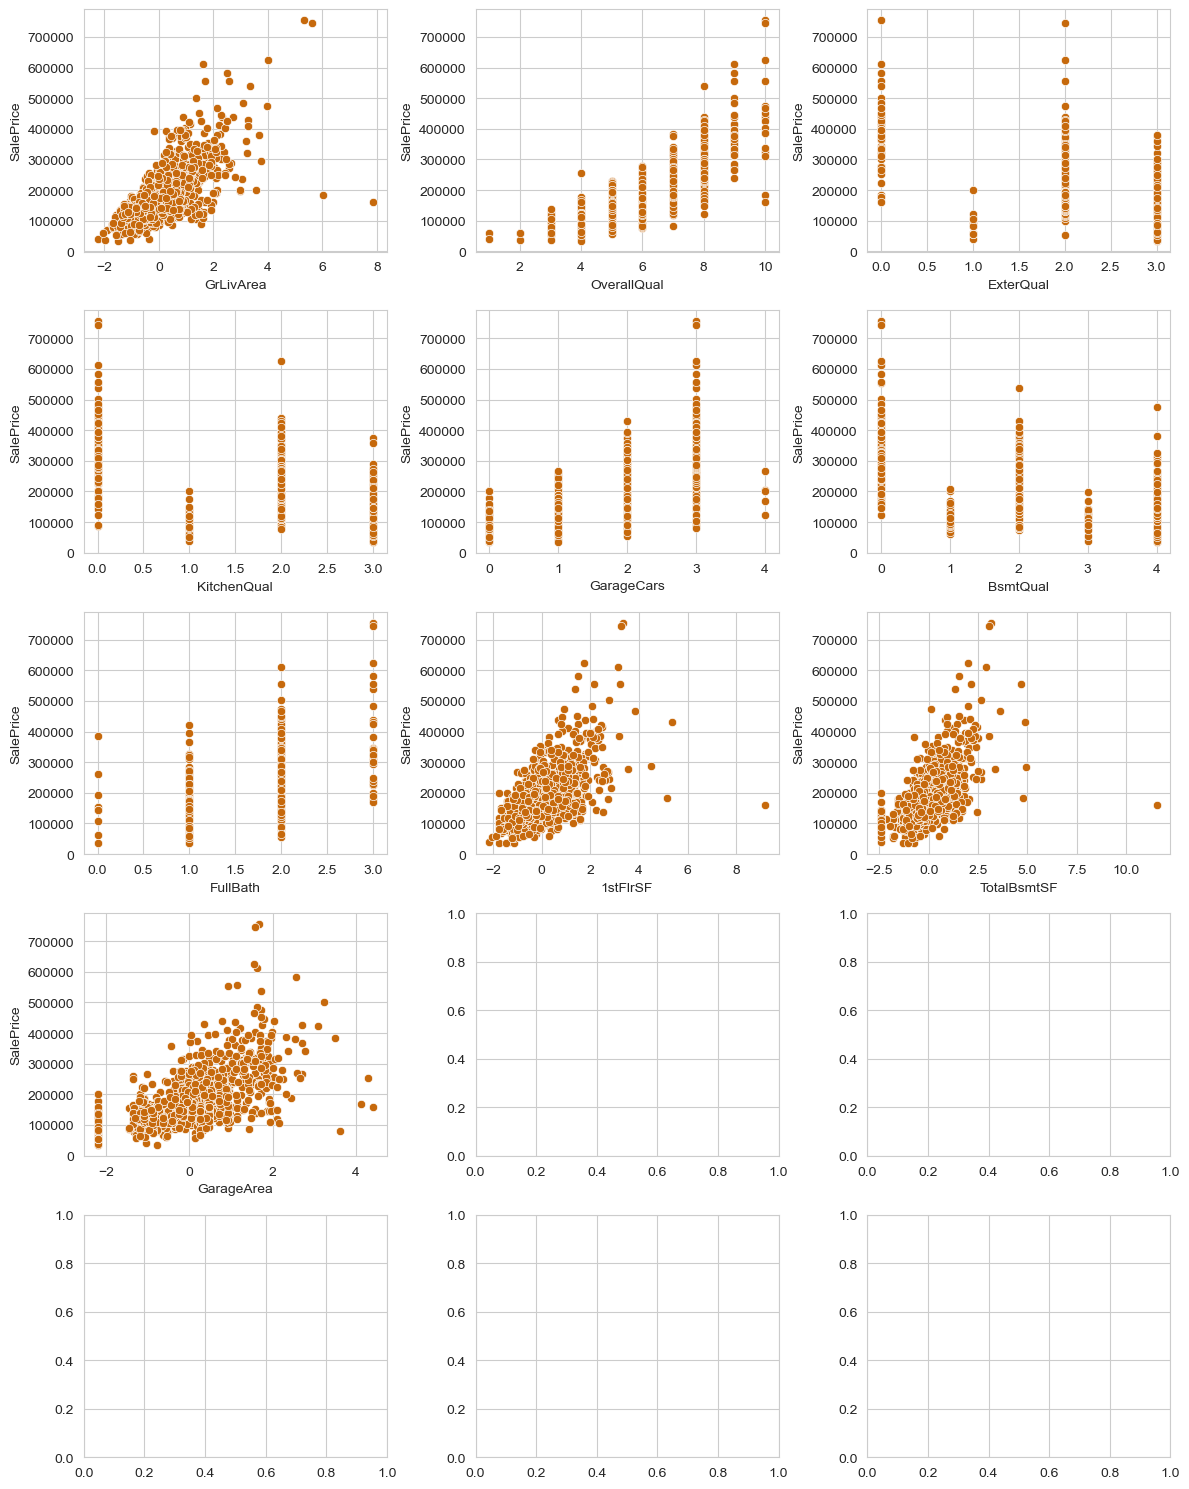

In [39]:
#SCATTERPLOT OF DF_TRAIN_RELIEF
sns.set_palette("PuOr")
sns.set_style("whitegrid")

fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(12, 15))

for i, column in enumerate(df_train_relief.columns):
    if column == "SalePrice":
        continue
    ax = axs[i // 3, i % 3]
    sns.scatterplot(x=column, y="SalePrice", data=df_train_relief, ax=ax)
    ax.set_xlabel(column)
    ax.set_ylabel("SalePrice")

plt.tight_layout()
plt.show()
